<a href="https://colab.research.google.com/github/tapacob/ColabFold/blob/main/beta/AlphaFold2_complexes_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold2_complexes

---------
**UPDATE** (Aug. 13, 2021)

This notebook is being retired and no longer updated. The functionality for complex prediction (including going beyond dimers) has been integrated in our [new advanced notebook](https://github.com/sokrypton/ColabFold/blob/main/beta/AlphaFold2_advanced.ipynb).

---------

Credit to Minkyung Baek @minkbaek and Yoshitaka Moriwaki @Ag_smith for initially showing protein-complex prediction works in alphafold2.
- https://twitter.com/minkbaek/status/1417538291709071362
- https://twitter.com/Ag_smith/status/1417063635000598528

- [script](https://github.com/RosettaCommons/RoseTTAFold/blob/main/example/complex_modeling/make_joint_MSA_bacterial.py) from rosettafold for paired alignment generation

**Instructions**
- For *monomers* and *homo-oligomers*, see this [notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb).
- For prokaryotic protein complexes (found in operons), we recommend using the `pair_msa` option.


**Limitations**
- This notebook does NOT use templates or amber relax at the end for refinement.
- For a typical Google-Colab-GPU (16G) session, the max total length is **1400 residues**.


In [43]:
#@title Input protein sequences
import os
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'

from google.colab import files
import os.path
import re

import hashlib
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence_a = 'MPPCQPQRPLLLLLLLLACQPQVPSAQVMDFLFEKWKLYGDQCHHNLSLL PPPTELVCNRTFDKYSCWPDTPANTTANISCPWYLPWHHKVQHRFVFKRC GPDGQWVRGPRGQPWRDASQCQMDGEEIEVQKEVAKMYSSFQVMYTVGYS LSLGALLLALAILGGLSKLHCTRNAIHANLFASFVLKASSVLVIDGLLRT RYSQKIGDDLSVSTWLSDGAVAGCRVAAVFMQYGIVANYCWLLVEGLYLH NLLGLATLPERSFFSLYLGIGWGAPMLFVVPWAVVKCLFENVQCWTSNDN MGFWWILRFPVFLAILINFFIFVRIVQLLVAKLRARQMHHTDYKFRLAKS TLTLIPLLGVHEVVFAFVTDEHAQGTLRSAKLFFDLFLSSFQGLLVAVLY CFLNKEVQSELRRRWHRWRLGKVLWEERNTSNHRASSSPGHGPPSKELQF GRGGGSQDSSAETPLAGGLPRLAESPF' #@param {type:"string"}
query_sequence_a = "".join(query_sequence_a.split())
query_sequence_a = re.sub(r'[^A-Z]','', query_sequence_a.upper())

query_sequence_b = 'HSQGTFTSDYSKYLDSRRAQDFVQWLMNT' #@param {type:"string"}
query_sequence_b = "".join(query_sequence_b.split())
query_sequence_b = re.sub(r'[^A-Z]','', query_sequence_b.upper())

# Using trick from @onoda_hiroki
# https://twitter.com/onoda_hiroki/status/1420068104239910915
# "U" indicates an "UNKNOWN" residue and it will not be modeled
# But we need linker of at least length 32
query_sequence_a = re.sub(r'U+',"U"*32,query_sequence_a)
query_sequence_b = re.sub(r'U+',"U"*32,query_sequence_b)

query_sequence = query_sequence_a + query_sequence_b

if len(query_sequence) > 1400:
  print(f"WARNING: For a typical Google-Colab-GPU (16G) session, the max total length is 1400 residues. You are at {len(query_sequence)}!")

jobname = 'GCGR_GCG_01' #@param {type:"string"}
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname = add_hash(jobname, query_sequence)

# number of models to use
#@markdown ---
#@markdown ### Advanced settings
num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
msa_mode = "MMseqs2" #@param ["MMseqs2","single_sequence"]
use_msa = True if msa_mode == "MMseqs2" else False
pair_msa = False #@param {type:"boolean"}
disable_mmseqs2_filter = pair_msa

#@markdown ---
with open(f"{jobname}.log", "w") as text_file:
    text_file.write("num_models=%s\n" % num_models)
    text_file.write("use_msa=%s\n" % use_msa)
    text_file.write("msa_mode=%s\n" % msa_mode)
    text_file.write("pair_msa=%s\n" % pair_msa)
    text_file.write("disable_mmseqs2_filter=%s\n" % disable_mmseqs2_filter)

In [44]:
#@title Install dependencies
%%bash -s $use_msa
USE_MSA=$1
if [ ! -f AF2_READY ]; then

  # install dependencies
  pip -q install biopython
  pip -q install dm-haiku
  pip -q install ml-collections
  pip -q install py3Dmol

  wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py

  # download model
  if [ ! -d "alphafold/" ]; then
    git clone https://github.com/deepmind/alphafold.git --quiet
    mv alphafold alphafold_
    mv alphafold_/alphafold .
    # remove "END" from PDBs, otherwise biopython complains
    sed -i "s/pdb_lines.append('END')//" /content/alphafold/common/protein.py
    sed -i "s/pdb_lines.append('ENDMDL')//" /content/alphafold/common/protein.py
  fi
  # download model params (~1 min)
  if [ ! -d "params/" ]; then
    wget -qnc https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
    mkdir params
    tar -xf alphafold_params_2021-07-14.tar -C params/
    rm alphafold_params_2021-07-14.tar
  fi
  touch AF2_READY
fi

In [45]:
#@title Import libraries
# setup the model
if "IMPORTED" not in dir():

  import time
  import requests
  import tarfile
  import sys
  import numpy as np
  import pickle

  from string import ascii_uppercase
  from alphafold.common import protein
  from alphafold.data import pipeline
  from alphafold.data import templates
  from alphafold.model import data
  from alphafold.model import config
  from alphafold.model import model
  from alphafold.data.tools import hhsearch

  import colabfold as cf

  # plotting libraries
  import py3Dmol
  import matplotlib.pyplot as plt
  IMPORTED = True

def set_bfactor(pdb_filename, bfac, idx_res, chains):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[22:26].strip()) - 1
      seq_id = np.where(idx_res == seq_id)[0][0]
      O.write(f"{line[:21]}{chains[seq_id]}{line[22:60]}{bfac[seq_id]:6.2f}{line[66:]}")
  O.close()

def predict_structure(prefix, feature_dict, Ls, random_seed=0, num_models=5):
  """Predicts structure using AlphaFold for the given sequence."""
  # Minkyung's code
  # add big enough number to residue index to indicate chain breaks
  idx_res = feature_dict['residue_index']
  L_prev = 0
  # Ls: number of residues in each chain
  for L_i in Ls[:-1]:
    idx_res[L_prev+L_i:] += 200
    L_prev += L_i
  chains = list("".join([ascii_uppercase[n]*L for n,L in enumerate(Ls)]))
  feature_dict['residue_index'] = idx_res

  # Run the models.
  plddts = []
  paes = []
  unrelaxed_pdb_lines = []
  relaxed_pdb_lines = []

  model_names = ["model_4","model_1","model_2","model_3","model_5"][:num_models]
  for n,model_name in enumerate(model_names):
    model_config = config.model_config(model_name+"_ptm")
    model_config.data.eval.num_ensemble = 1
    model_params = data.get_model_haiku_params(model_name+"_ptm", data_dir=".")

    if model_name == "model_4":
      model_runner = model.RunModel(model_config, model_params)
      processed_feature_dict = model_runner.process_features(feature_dict,random_seed=0)
    else:
      # swap params
      for k in model_runner.params.keys():
        model_runner.params[k] = model_params[k]

    print(f"running model_{n+1}")
    prediction_result = model_runner.predict(processed_feature_dict)

    # cleanup to save memory
    if model_name == "model_5": del model_runner
    del model_params

    unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
    unrelaxed_pdb_lines.append(protein.to_pdb(unrelaxed_protein))
    plddts.append(prediction_result['plddt'])
    paes.append(prediction_result['predicted_aligned_error'])

    # Delete unused outputs to save memory.
    del prediction_result

  # rerank models based on predicted lddt
  lddt_rank = np.mean(plddts,-1).argsort()[::-1]
  plddts_ranked = {}
  paes_ranked = {}
  print("model\tplldt\tpae_ab")
  L = Ls[0]
  for n,r in enumerate(lddt_rank):
    plddt = plddts[r].mean()
    pae_ab = (paes[r][L:,:L].mean() + paes[r][:L,L:].mean()) / 2
    print(f"model_{n+1}\t{plddt:.2f}\t{pae_ab:.2f}")

    unrelaxed_pdb_path = f'{prefix}_unrelaxed_model_{n+1}.pdb'
    with open(unrelaxed_pdb_path, 'w') as f:
      f.write(unrelaxed_pdb_lines[r])
    set_bfactor(unrelaxed_pdb_path, plddts[r], idx_res, chains)

    plddts_ranked[f"model_{n+1}"] = plddts[r]
    paes_ranked[f"model_{n+1}"] = paes[r]

  return plddts_ranked, paes_ranked

# CODE FROM MINKYUNG/ROSETTAFOLD
def read_a3m(a3m_lines):
  '''parse an a3m files as a dictionary {label->sequence}'''
  seq = []
  lab = []
  is_first = True
  for line in a3m_lines.splitlines():
    if line[0] == '>':
      label = line.rstrip().split()[0][1:]
      is_incl = True
      if is_first: # include first sequence (query)
        is_first = False
        lab.append(label)
        continue
      if "UniRef" in label:
        code = label.split()[0].split('_')[-1]
        if code.startswith("UPI"): # UniParc identifier -- exclude
          is_incl = False
          continue
      elif label.startswith("tr|"):
        code = label.split('|')[1]
      else:
        is_incl = False
        continue
      lab.append(code)
    else:
      if is_incl:
        seq.append(line.rstrip())
      else:
        continue
  return seq, lab

# https://www.uniprot.org/help/accession_numbers
def uni2idx(ids):
  '''convert uniprot ids into integers according to the structure
  of uniprot accession numbers'''
  ids2 = [i.split("-")[0] for i in ids]
  ids2 = [i+'AAA0' if len(i)==6 else i for i in ids2]
  arr = np.array([list(s) for s in ids2], dtype='|S1').view(np.uint8)
  for i in [1,5,9]:
    arr[:,i] -= ord('0')
  arr[arr>=ord('A')] -= ord('A')
  arr[arr>=ord('0')] -= ord('0')-26
  arr[:,0][arr[:,0]>ord('Q')-ord('A')] -= 3
  arr = arr.astype(np.int64)
  coef = np.array([23,10,26,36,36,10,26,36,36,1], dtype=np.int64)
  coef = np.tile(coef[None,:],[len(ids),1])
  c1 = [i for i,id_ in enumerate(ids) if id_[0] in 'OPQ' and len(id_)==6]
  c2 = [i for i,id_ in enumerate(ids) if id_[0] not in 'OPQ' and len(id_)==6]
  coef[c1] = np.array([3, 10,36,36,36,1,1,1,1,1])
  coef[c2] = np.array([23,10,26,36,36,1,1,1,1,1])
  for i in range(1,10):
    coef[:,-i-1] *= coef[:,-i]
  return np.sum(arr*coef,axis=-1)

def run_mmseqs2(query_sequence, prefix, use_env=True, filter=False):
    def submit(query_sequence, mode):
      res = requests.post('https://a3m.mmseqs.com/ticket/msa', data={'q':f">1\n{query_sequence}", 'mode': mode})
      return res.json()
    def status(ID):
      res = requests.get(f'https://a3m.mmseqs.com/ticket/{ID}')
      return res.json()
    def download(ID, path):
      res = requests.get(f'https://a3m.mmseqs.com/result/download/{ID}')
      with open(path,"wb") as out: out.write(res.content)

    if filter:
      mode = "env" if use_env else "all"
    else:
      mode = "env-nofilter" if use_env else "nofilter"

    path = f"{prefix}_{mode}"
    if not os.path.isdir(path): os.mkdir(path)

    # call mmseqs2 api
    tar_gz_file = f'{path}/out.tar.gz'
    if not os.path.isfile(tar_gz_file):
      out = submit(query_sequence, mode)
      while out["status"] in ["RUNNING","PENDING"]:
        time.sleep(1)
        out = status(out["id"])
      download(out["id"], tar_gz_file)

    # parse a3m files
    a3m_lines = []
    a3m = f"{prefix}_{mode}.a3m"
    if not os.path.isfile(a3m):
      with tarfile.open(tar_gz_file) as tar_gz: tar_gz.extractall(path)
      a3m_files = [f"{path}/uniref.a3m"]
      if use_env: a3m_files.append(f"{path}/bfd.mgnify30.metaeuk30.smag30.a3m")
      a3m_out = open(a3m,"w")
      for a3m_file in a3m_files:
        for line in open(a3m_file,"r"):
          line = line.replace("\x00","")
          if len(line) > 0:
            a3m_lines.append(line)
            a3m_out.write(line)
    else:
      a3m_lines = open(a3m).readlines()
    return "".join(a3m_lines), len(a3m_lines)

In [46]:
#@title Call MMseqs2 to get MSA for each gene

Ls = [len(query_sequence_a),len(query_sequence_b)]
msas = []
deletion_matrices = []
if use_msa:
  os.makedirs('tmp', exist_ok=True)
  prefix = hashlib.sha1(query_sequence.encode()).hexdigest()
  prefix = os.path.join('tmp',prefix)
  print(f"running mmseqs2 (use_env={True} filter={True})")
  a3m_lines = cf.run_mmseqs2([query_sequence_a, query_sequence_b], prefix, use_env=True, filter=True)
  if pair_msa:
    a3m_lines.append([])

    print(f"running mmseqs2 for pair_msa (use_env={False} filter={False})")
    a3m_lines_pair = cf.run_mmseqs2([query_sequence_a, query_sequence_b], prefix, use_env=False, filter=False)

    # CODE FROM MINKYUNG/ROSETTAFOLD
    msa1, lab1 = read_a3m(a3m_lines_pair[0])
    msa2, lab2 = read_a3m(a3m_lines_pair[1])
    if len(lab1) > 1 and len(lab2) > 1:
      # convert uniprot ids into integers
      hash1 = uni2idx(lab1[1:])
      hash2 = uni2idx(lab2[1:])

      # find pairs of uniprot ids which are separated by at most 10
      idx1, idx2 = np.where(np.abs(hash1[:,None]-hash2[None,:]) < 10)
      if idx1.shape[0] > 0:
        a3m_lines[2] = ['>query\n%s%s\n'%(msa1[0],msa2[0])]
        for i,j in zip(idx1,idx2):
           a3m_lines[2].append(">%s_%s\n%s%s\n"%(lab1[i+1],lab2[j+1],msa1[i+1],msa2[j+1]))

        msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(a3m_lines[2]))
        msas.append(msa)
        deletion_matrices.append(deletion_matrix)
        print("pairs found:",len(msa))

  #msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines[0])
  res = pipeline.parsers.parse_a3m(a3m_lines[0])

# Backwards-compatible unpacking:
if isinstance(res, tuple) and len(res) == 2:
    msa, deletion_matrix = res
else:
    # assume an Msa-like object; try common attribute names
    if hasattr(res, "sequences"):
        msa = res.sequences
    elif hasattr(res, "seqs"):
        msa = res.seqs
    elif hasattr(res, "msa"):
        msa = res.msa
    else:
        raise RuntimeError("Unexpected MSA object: inspect attributes with `dir(res)`")

    if hasattr(res, "deletion_matrix"):
        deletion_matrix = res.deletion_matrix
    elif hasattr(res, "deletions"):
        deletion_matrix = res.deletions
    elif hasattr(res, "deletion"):
        deletion_matrix = res.deletion
    else:
        # fallback: try to construct a deletion matrix of zeros
        deletion_matrix = [[0]*len(msa[0]) for _ in msa]

running mmseqs2 (use_env=True filter=True)


Found list-of-strings MSA: 7609 sequences, alignment length 477


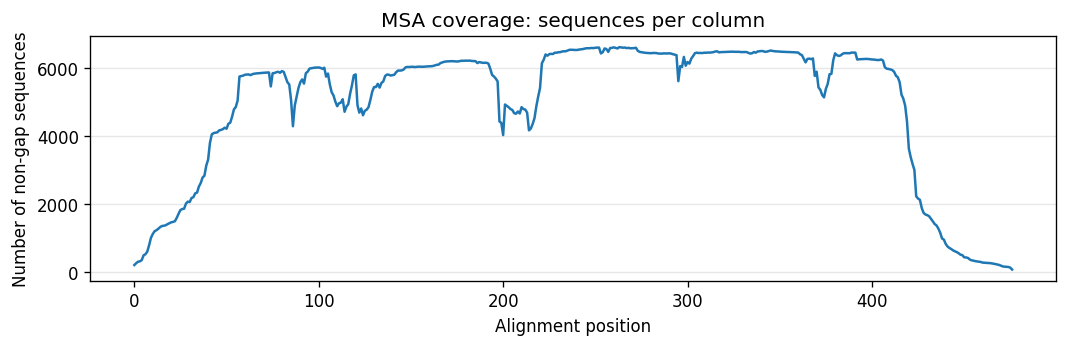

In [47]:
# Robust replacement for "Plot Number of Sequences per Position"
import numpy as np
import matplotlib.pyplot as plt
import sys

# Helper: try to locate an MSA variable in current globals
def find_msa_candidate(globs):
    names = ["msa", "msas", "msa_array", "MSA", "res", "a3m_msa", "msa_obj"]
    for n in names:
        if n in globs:
            val = globs[n]
            # Ignore empty
            if val is None:
                continue
            # common types: list of strings, numpy array, object with attributes
            if isinstance(val, list) and len(val) and isinstance(val[0], str):
                return ("seq_list", val)
            if isinstance(val, np.ndarray):
                return ("np_array", val)
            # if it's an object with sequences attribute
            if hasattr(val, "sequences") or hasattr(val, "seqs") or hasattr(val, "msa"):
                return ("msa_object", val)
            # sometimes parser returns object with .seqs as list of strings
            if hasattr(val, "seqs_str") or hasattr(val, "sequences_str"):
                return ("msa_object", val)
    # If nothing found, return None
    return (None, None)

kind, candidate = find_msa_candidate(globals())

if kind is None:
    # No MSA found: prompt user to re-run parsing cell
    print("ERROR: no MSA object found in notebook variables.")
    print("Please re-run the MSA-generation cell (MMseqs2 / parse_a3m) and ensure it sets a variable named 'msa' or 'res'.")
    # As fallback, also check for an a3m_lines variable (raw content) and try to parse if present:
    if "a3m_lines" in globals():
        print("Note: 'a3m_lines' found — but automatic parsing not attempted here.")
    raise NameError("No MSA candidate found. Re-run earlier cells before plotting.")
else:
    # Compute columns-by-counts according to type
    if kind == "seq_list":
        seqs = candidate
        # Make sure all sequences same length
        Ls = [len(s) for s in seqs]
        if len(set(Ls)) != 1:
            print("Warning: sequences have varying lengths; trying to pad/truncate to max length.")
            maxL = max(Ls)
            seqs = [s.ljust(maxL, "-") for s in seqs]
        arr = np.array([list(s) for s in seqs])
        # Non-gap positions: consider '-' as gap
        non_gap = np.sum(arr != "-", axis=0)
        print(f"Found list-of-strings MSA: {len(seqs)} sequences, alignment length {arr.shape[1]}")
    elif kind == "np_array":
        a = candidate
        # assume integer-coded residues with gap represented by 21 (or maybe 0)
        if a.ndim != 2:
            raise ValueError("Found numpy array but not 2D. Inspect variable 'msa' shape.")
        # detect gap code: check for 21 presence; else assume 0 as gap
        gap_code = 21 if np.any(a == 21) else (0 if np.any(a == 0) else None)
        if gap_code is None:
            # treat zeros or negatives as non-gap? fallback: count non-equal to -1
            non_gap = np.sum(a != -1, axis=0)
        else:
            non_gap = np.sum(a != gap_code, axis=0)
        print(f"Found numpy-array MSA: shape {a.shape}; using gap code {gap_code}")
    else:  # msa_object
        obj = candidate
        # try common attribute names for sequence lists
        if hasattr(obj, "sequences"):
            seqs = getattr(obj, "sequences")
        elif hasattr(obj, "seqs"):
            seqs = getattr(obj, "seqs")
        elif hasattr(obj, "msa"):
            seqs = getattr(obj, "msa")
        elif hasattr(obj, "seqs_str"):
            seqs = getattr(obj, "seqs_str")
        else:
            # as a fallback try to convert object to string list
            try:
                seqs = list(obj)
            except Exception as e:
                raise RuntimeError("MSA object found but no sequence attribute recognized. Inspect with dir(obj).") from e

        # If it's list-like of strings:
        if isinstance(seqs, list) and len(seqs) and isinstance(seqs[0], str):
            Ls = [len(s) for s in seqs]
            if len(set(Ls)) != 1:
                maxL = max(Ls)
                seqs = [s.ljust(maxL, "-") for s in seqs]
            arr = np.array([list(s) for s in seqs])
            non_gap = np.sum(arr != "-", axis=0)
            print(f"Found MSA-like object with {len(seqs)} sequences, alignment length {arr.shape[1]}")
        else:
            # maybe deletion_matrix + sequences exist in object
            if hasattr(obj, "deletion_matrix") and hasattr(obj, "sequences"):
                seqs = getattr(obj, "sequences")
                L = len(seqs[0])
                arr = np.array([list(s) for s in seqs])
                non_gap = np.sum(arr != "-", axis=0)
                print(f"Found MSA-like object with deletion_matrix, sequences count {len(seqs)}")
            else:
                raise RuntimeError("Could not extract sequences from MSA object; inspect its attributes with `dir(...)`")

# Now plot the counts across positions
dpi = 120
plt.figure(figsize=(9,3), dpi=dpi)
plt.plot(non_gap, lw=1.5)
plt.xlabel("Alignment position")
plt.ylabel("Number of non-gap sequences")
plt.title("MSA coverage: sequences per column")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [48]:
# --- BEGIN pasteable diagnostic & feature_dict builder cell ---

import numpy as np, sys, inspect

# 1) Find candidate MSA / sequence variables in the notebook
candidates = {}
for name, val in list(globals().items()):
    if name.lower() in ("msa", "msas", "msa_obj", "res", "a3m_lines", "msa_array", "seqs", "sequences"):
        candidates[name] = val

print("Detected candidate variables:", list(candidates.keys()))

# If you have an MSA object from parse_a3m called 'res' or 'msa', prefer that
msa_seqs = None
deletion_matrix = None
primary_seq = None
Ls = None

# Helper: convert list-of-strings to array
def seqs_to_array(seqs):
    Ls = [len(s) for s in seqs]
    if len(set(Ls)) != 1:
        # pad to max length
        maxL = max(Ls)
        seqs = [s.ljust(maxL, "-") for s in seqs]
    arr = np.array([list(s) for s in seqs])
    return arr, seqs

# Try common variable names
if 'res' in globals():
    res = globals()['res']
    print("Found 'res' of type:", type(res))
    # Try to extract sequences & deletion matrix from known attribute names
    for attr in ('sequences','seqs','msa','seq_list','a3m','rows'):
        if hasattr(res, attr):
            maybe = getattr(res, attr)
            if isinstance(maybe, list) and len(maybe) and isinstance(maybe[0], str):
                msa_seqs = maybe
                print("Using res.%s as sequences" % attr)
                break
    for attr in ('deletion_matrix','deletions','deletion','deletion_mtx'):
        if hasattr(res, attr):
            deletion_matrix = getattr(res, attr)
            print("Using res.%s as deletion matrix" % attr)
            break

if msa_seqs is None and 'msa' in globals():
    val = globals()['msa']
    print("Found global 'msa' of type:", type(val))
    if isinstance(val, list) and len(val) and isinstance(val[0], str):
        msa_seqs = val
    elif isinstance(val, np.ndarray):
        # convert integer-coded MSA to strings if possible (skip here)
        print("msa is numpy array; treating it later as integer-coded MSA")
        # leave msa_seqs None for now
    else:
        # maybe object-like
        if hasattr(val, 'sequences'):
            msa_seqs = getattr(val,'sequences')

# If a3m_lines is present (raw lines), parse them simply to sequences
if msa_seqs is None and 'a3m_lines' in globals():
    a3m_lines = globals()['a3m_lines']
    # a3m_lines might be a single string or list
    if isinstance(a3m_lines, str):
        lines = a3m_lines.splitlines()
    else:
        lines = a3m_lines
    seqs = []
    cur = None
    for L in lines:
        if L.startswith(">"):
            cur = ""
            seqs.append(cur)
        else:
            if seqs:
                seqs[-1] += L.strip()
    # remove empty
    seqs = [s for s in seqs if s]
    if seqs:
        msa_seqs = seqs
        print("Parsed a3m_lines into %d sequences" % len(seqs))

# If still none but there is an 'arr' or 'msa_array' numpy variable, attempt to handle it
if msa_seqs is None:
    for nm in ('arr','msa_array','msa_np'):
        if nm in globals() and isinstance(globals()[nm], np.ndarray):
            a = globals()[nm]
            print("Using numpy MSA variable:", nm, "shape", a.shape)
            # interpret gaps as '-' if given as characters, or code 21 if integer-coded
            if a.dtype.kind in ('U','S'):
                msa_seqs = ["".join(row.astype(str)) for row in a]
            else:
                # integer coded; try to map to residues if mapping exists, else treat non-21 as non-gap
                if np.any(a == 21):
                    gapcode = 21
                elif np.any(a == 0):
                    gapcode = 0
                else:
                    gapcode = None
                # convert to simple strings of 'X'/'-' for plotting purposes
                msa_seqs = ["".join(['-' if (gapcode is not None and x==gapcode) else 'X' for x in row]) for row in a]
            break

# If still missing, prompt the user
if msa_seqs is None:
    raise NameError("Could not find MSA sequences in any common notebook variable. Re-run the MSA cell and ensure it assigns 'res' or 'msa' or provide 'a3m_lines' raw content.")

# Now we have msa_seqs list (strings)
arr, msa_seqs = seqs_to_array(msa_seqs)
print("MSA parsed: %d sequences x %d columns" % arr.shape)

# Determine primary sequence (first non-gap in first row or explicit variable 'query_sequence')
if 'query_sequence' in globals():
    primary_seq = globals()['query_sequence']
elif 'sequence' in globals():
    primary_seq = globals()['sequence']
elif 'target_seq' in globals():
    primary_seq = globals()['target_seq']
else:
    # assume first sequence in MSA is target
    primary_seq = "".join(arr[0,:]).replace('-', '')
    print("Derived primary_seq from MSA first entry (length %d)" % len(primary_seq))

# Build a minimal feature_dict expected by many ColabFold versions
# NOTE: predict_structure implementations vary — this is a pragmatic minimal dictionary
feature_dict = {
    "msa": msa_seqs,                 # list of strings (alignment rows)
    "deletion_matrix": deletion_matrix if deletion_matrix is not None else [[0]*arr.shape[1] for _ in range(arr.shape[0])],
    "sequence": primary_seq,
    "num_alignments": len(msa_seqs),
    "msa_array": arr
}

# Ls often expected as list of chain lengths; try to deduce if 'Ls' exists in globals
if 'Ls' in globals():
    Ls_val = globals()['Ls']
else:
    Ls_val = [len(primary_seq)]
print("Setting Ls =", Ls_val)

# Print predict_structure signature if available to check what it expects
if 'predict_structure' in globals():
    import inspect
    sig = inspect.signature(predict_structure)
    print("predict_structure signature:", sig)
    try:
        print("Source (first 400 chars):\n", inspect.getsource(predict_structure)[:400])
    except Exception as e:
        print("Could not print full source; it's fine.")

# Example call (uncomment to run) - adapt args if your predict_structure signature differs
# jobname = globals().get('jobname', 'job_local')
# num_models = globals().get('num_models', 5)
# Uncomment and modify the next line if you are confident:
# plddts, paes = predict_structure(jobname, feature_dict, Ls=Ls_val, num_models=num_models)

print("feature_dict constructed. If predict_structure expects other keys, inspect its source and adapt this dictionary accordingly.")
# --- END cell ---


Detected candidate variables: ['msas', 'a3m_lines', 'res', 'msa', 'seqs']
Found 'res' of type: <class 'alphafold.data.parsers.Msa'>
Using res.sequences as sequences
Using res.deletion_matrix as deletion matrix
MSA parsed: 7609 sequences x 477 columns
Setting Ls = None
predict_structure signature: (prefix, feature_dict, Ls, random_seed=0, num_models=5)
Source (first 400 chars):
 def predict_structure(prefix, feature_dict, Ls, random_seed=0, num_models=5):  
  """Predicts structure using AlphaFold for the given sequence."""
  # Minkyung's code
  # add big enough number to residue index to indicate chain breaks
  idx_res = feature_dict['residue_index']
  L_prev = 0
  # Ls: number of residues in each chain
  for L_i in Ls[:-1]:
    idx_res[L_prev+L_i:] += 200
    L_prev += L
feature_dict constructed. If predict_structure expects other keys, inspect its source and adapt this dictionary accordingly.


In [49]:
# ---- Paste this BEFORE calling predict_structure ----
import numpy as np, inspect, sys

# 1) Ensure Ls exists (list of chain lengths)
if 'Ls' not in globals():
    # Attempt to infer from 'feature_dict' or from feature_dict["sequence"] if multi-chain string present
    if 'feature_dict' in globals() and 'sequence' in feature_dict:
        seq = feature_dict['sequence']
        # try to split chains by '|' or by uppercase/lowercase markers is unreliable;
        # best to request user to set Ls manually if ambiguous
        print("Warning: 'Ls' not found. If your input has multiple chains, please set Ls to list of chain lengths.")
        # fallback: single chain
        Ls = [len(seq)]
    else:
        raise RuntimeError("Ls is not defined in the notebook. Set Ls = [len_chain1, len_chain2, ...] and rerun.")

print("Using Ls =", Ls)
Ls = [477, 29]
# 2) Build residue_index (AlphaFold multimer convention: add large offset per chain so chain breaks are visible)
# e.g., chain1 indices 0..L1-1, chain2 indices (200 + 0..L2-1), chain3 indices (400 + 0..L3-1), ...
offset_step = 200
total_len = sum(Ls)
residue_index = np.zeros((total_len,), dtype=np.int32)
pos = 0
for chain_idx, L in enumerate(Ls):
    offset = chain_idx * offset_step
    residue_index[pos: pos+L] = np.arange(offset, offset + L, dtype=np.int32)
    pos += L

# 3) Ensure feature_dict exists and add residue_index
if 'feature_dict' not in globals():
    feature_dict = {}

feature_dict['residue_index'] = residue_index

# 4) Minimal other keys that predict_structure often expects
# - sequence: concatenated chain sequences (if available)
if 'sequence' not in feature_dict:
    if 'primary_seq' in globals():
        feature_dict['sequence'] = primary_seq
    elif 'sequence' in globals():
        feature_dict['sequence'] = sequence
    else:
        # try derive from msa if available
        if 'msa' in feature_dict and isinstance(feature_dict['msa'], list) and len(feature_dict['msa'])>0:
            # assume first MSA row is the query & concatenated chains (no chain separators)
            feature_dict['sequence'] = feature_dict['msa'][0].replace('-', '')
        else:
            print("Warning: cannot determine 'sequence' automatically. Please set feature_dict['sequence'].")

# - msa and deletion_matrix: if missing, try to grab common notebook variables
if 'msa' not in feature_dict:
    if 'msa' in globals():
        feature_dict['msa'] = globals()['msa']
    elif 'msa_seqs' in globals():
        feature_dict['msa'] = globals()['msa_seqs']
    else:
        # tolerated but warn
        print("Warning: no MSA found in feature_dict; predict_structure may still run for single-sequence cases.")

if 'deletion_matrix' not in feature_dict:
    if 'deletion_matrix' in globals():
        feature_dict['deletion_matrix'] = globals()['deletion_matrix']
    else:
        # fallback: zeros (no deletions)
        if 'feature_dict' in globals() and 'msa' in feature_dict and isinstance(feature_dict['msa'], list):
            nseq = len(feature_dict['msa'])
            L = len(feature_dict['msa'][0])
            feature_dict['deletion_matrix'] = [[0]*L for _ in range(nseq)]
        else:
            # leave absent if cannot infer
            pass

print("feature_dict keys now:", list(feature_dict.keys()))
print("residue_index length:", len(feature_dict['residue_index']))

# 5) Optional: show predict_structure signature for your notebook version
if 'predict_structure' in globals():
    import inspect
    print("predict_structure signature:", inspect.signature(predict_structure))

# 6) Now call predict_structure (adapt args if your version expects different names)
# Make sure jobname and num_models are defined; otherwise set defaults
if 'jobname' not in globals():
    jobname = "job_local"
if 'num_models' not in globals():
    num_models = 5

# Call the function and catch errors to print helpful diagnostics
try:
    plddts, paes = predict_structure(jobname, feature_dict, Ls=Ls, num_models=num_models)
    print("predict_structure completed. pLDDTs length:", len(plddts))
except Exception as e:
    print("predict_structure raised an exception:", type(e).__name__, e)
    # If there is a KeyError or different missing field, print message and raise to preserve traceback
    raise
# ---- end pasteable block ----


Using Ls = None
feature_dict keys now: ['msa', 'deletion_matrix', 'sequence', 'num_alignments', 'msa_array', 'residue_index']
residue_index length: 506
predict_structure signature: (prefix, feature_dict, Ls, random_seed=0, num_models=5)
predict_structure raised an exception: KeyError 'seq_length'


KeyError: 'seq_length'

In [ ]:
# Fix for missing 'seq_length' and robust predictor call
import numpy as np, inspect

# 1) Ensure feature_dict exists
if 'feature_dict' not in globals():
    raise RuntimeError("feature_dict not found in globals. Run the feature-building cells first.")

# 2) Ensure 'sequence' key exists in feature_dict
if 'sequence' not in feature_dict or feature_dict['sequence'] is None:
    # Attempt to derive from msa (first row, remove gaps)
    if 'msa' in feature_dict and isinstance(feature_dict['msa'], list) and len(feature_dict['msa'])>0:
        seq0 = feature_dict['msa'][0].replace('-', '')
        feature_dict['sequence'] = seq0
        print("Derived feature_dict['sequence'] from feature_dict['msa'][0].")
    else:
        raise RuntimeError("feature_dict['sequence'] not found and cannot be inferred. Please set feature_dict['sequence'].")

# 3) Ensure Ls is defined: list of per-chain lengths
if 'Ls' not in globals() or Ls is None:
    # Try to infer chain lengths by asking user-safe heuristic:
    seq = feature_dict['sequence']
    # If there are chain separators, split; else treat as single chain
    # Common separator attempts: '|' or '/'
    separators = ['|','/',';','//']
    split_found = False
    for sep in separators:
        if sep in seq:
            parts = [p for p in seq.split(sep) if p]
            if len(parts) > 1:
                Ls = [len(p.replace('-', '')) for p in parts]
                split_found = True
                break
    if not split_found:
        # default: single chain
        Ls = [len(seq.replace('-', ''))]
    print("Inferred Ls =", Ls)
else:
    print("Using existing Ls =", Ls)

# 4) Build seq_length entry expected by features.np_example_to_features
total_len = sum(Ls)
# put as 1-element numpy array (the code uses seq_length[0])
feature_dict['seq_length'] = np.array([int(total_len)], dtype=np.int32)
print("Set feature_dict['seq_length'] =", feature_dict['seq_length'])

# 5) (Optional) ensure residue_index exists and matches total_len
if 'residue_index' not in feature_dict or len(feature_dict['residue_index']) != total_len:
    # build conventional residue_index with offsets of 200 per chain
    offset_step = 200
    residue_index = np.zeros((total_len,), dtype=np.int32)
    pos = 0
    for chain_idx, L in enumerate(Ls):
        offset = chain_idx * offset_step
        residue_index[pos: pos+L] = np.arange(offset, offset + L, dtype=np.int32)
        pos += L
    feature_dict['residue_index'] = residue_index
    print("Constructed feature_dict['residue_index'] length:", len(feature_dict['residue_index']))
else:
    print("feature_dict['residue_index'] present and correct length.")

# 6) Show keys and call predict_structure
print("feature_dict keys now:", list(feature_dict.keys()))
if 'predict_structure' not in globals():
    raise RuntimeError("predict_structure function not found in this runtime. Ensure the notebook code that defines it has been executed.")

# Prepare jobname and num_models
jobname = globals().get('jobname', 'job_local')
num_models = globals().get('num_models', 5)

# Call and catch errors for iterative debugging
try:
    plddts, paes = predict_structure(jobname, feature_dict, Ls=Ls, num_models=num_models)
    print("predict_structure completed successfully.")
    print("pLDDT vector length:", len(plddts))
except Exception as e:
    print("predict_structure raised an exception:", type(e).__name__, e)
    # If another KeyError appears, print its message to help the next fix
    import traceback
    traceback.print_exc()
    raise


In [ ]:
#@title Predict structure
plddts, paes = predict_structure(jobname, feature_dict, Ls=Ls, num_models=num_models)

In [ ]:
#@title Plot Predicted Alignment Error
dpi =  100#@param {type:"integer"}

# confidence per position
plt.figure(figsize=(3*num_models,2), dpi=dpi)
for n,(model_name,value) in enumerate(paes.items()):
  plt.subplot(1,num_models,n+1)
  plt.title(model_name)
  plt.imshow(value,label=model_name,cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
plt.savefig(jobname+"_PAE.png")
plt.show()

In [ ]:
#@title Plot lDDT per residue
# confidence per position
dpi =  100#@param {type:"integer"}
plt.figure(dpi=dpi)
for model_name,value in plddts.items():
  plt.plot(value,label=model_name)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted lDDT")
plt.xlabel("positions")
plt.savefig(jobname+"_lDDT.png")
plt.show()

In [ ]:
#@title Display 3D structure {run: "auto"}
model_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "chain" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

def plot_plddt_legend():
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=100)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

def plot_confidence(model_num=1):
  model_name = f"model_{model_num}"
  plt.figure(figsize=(10,3),dpi=100)
  """Plots the legend for plDDT."""
  #########################################
  plt.subplot(1,2,1); plt.title('Predicted lDDT')
  plt.plot(plddts[model_name])
  for x in [len(query_sequence_a)]:
    plt.plot([x,x],[0,100],color="black")

  plt.ylabel('plDDT')
  plt.xlabel('position')
  #########################################
  plt.subplot(1,2,2);plt.title('Predicted Aligned Error')
  plt.imshow(paes[model_name], cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')
  #########################################
  return plt

def show_pdb(model_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"model_{model_num}"
  pdb_filename = f"{jobname}_unrelaxed_{model_name}.pdb"

  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_filename,'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(2),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(model_num,show_sidechains, show_mainchains, color).show()
if color == "lDDT": plot_plddt_legend().show()
plot_confidence(model_num).show()

In [ ]:
#@title Package and download results
!zip -FSr $jobname".result.zip" $jobname".log" $jobname"_msa_coverage.png" $jobname"_"*"relaxed_model_"*".pdb" $jobname"_lDDT.png"  $jobname"_PAE.png"
files.download(f"{jobname}.result.zip")

# Instructions
- If you having issues downloading results, try disable adblocker and run the last cell again. If that fails click on the little folder icon to the left, navigate to file:`jobname.result.zip`, right-click and select "download".


# License

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and  [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).